<a href="https://colab.research.google.com/github/Pablobm3/Detector-de-Balsas/blob/main/pruebaUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import numpy as np
from PIL import Image
import cv2
from skimage.measure import label, regionprops
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import io,measure

def crear_mascara_mejorada(imagen_path, salida_path):
  """
  Crea una máscara binaria detectando balsas por color y forma geométrica,
  mejorada para incluir balsas más pequeñas y refinar los contornos.

  Args:
      imagen_path (str): Ruta de la imagen original.
      salida_path (str): Ruta para guardar la máscara generada.
  """
  # Cargar imagen
  img = np.array(Image.open(imagen_path))

  hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)


  maskrgb = cv2.inRange(img,(17, 9, 27), (47, 12, 101))
  maskhsv = cv2.inRange(hsv, (100, 50, 20), (130, 255, 80))
  maskhsv1 = cv2.inRange(hsv, (0,0,0), (255, 255, 30))
  maskycrcb = cv2.inRange(ycrcb, (0, 135, 85), (255, 170, 120))
  maskyrcrcb1 = cv2.inRange(ycrcb, (0, 135, 85), (100, 175, 135))
  maskyrcrcb2 = cv2.inRange(ycrcb, (0, 0, 0), (30, 255, 255))
  mascara_color = cv2.bitwise_or(maskhsv, maskhsv1)
  mascara_color = cv2.bitwise_or(mascara_color, maskrgb)
  mascara_color = cv2.bitwise_or(mascara_color, maskycrcb)
  mascara_color = cv2.bitwise_or(mascara_color, maskyrcrcb1)
  mascara_color = cv2.bitwise_or(mascara_color, maskyrcrcb2)






  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))  # Adjust kernel size
  mascara_morfo = cv2.morphologyEx(mascara_color, cv2.MORPH_OPEN, kernel, iterations=2)
  mascara_morfo = cv2.morphologyEx(mascara_morfo, cv2.MORPH_CLOSE, kernel,iterations=1)

  # Suavizar bordes para contornos más precisos
  mascara_suavizada = cv2.GaussianBlur(mascara_morfo, (5, 5), 0)


    # Encontrar contornos
  contornos, _ = cv2.findContours(mascara_suavizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  mascara_final = np.zeros_like(mascara_morfo)

      # Filtrar contornos basados en forma y tamaño
  for contorno in contornos:
          # Calcular características del contorno
    area = cv2.contourArea(contorno)
    perimetro = cv2.arcLength(contorno, True)
    x, y, w, h = cv2.boundingRect(contorno)

          # Filtros geométricos
    if area > 0.00000000000001:  # Detectar balsas pequeñas
        relacion_aspecto = w / h if w > h else h / w
        circularidad = (4 * np.pi * area) / (perimetro ** 2) if perimetro > 0 else 0

              # Aceptar contornos rectangulares o cuadrados con baja circularidad
        if 0.000000000001 <= relacion_aspecto <= 10000000.0 and circularidad < 500000:
                    # Agregar contorno a la máscara final
           cv2.drawContours(mascara_final, [contorno], -1, 255, -1)

  # Etiquetar regiones
  labeled_mask = measure.label(mascara_final)

  # Calcular propiedades de las regiones
  regions = regionprops(labeled_mask)

  # Definir umbral de área (ajusta este valor según tus necesidades)
  area_threshold = 6000

  # Filtrar regiones por área
  filtered_regions = [region for region in regions if region.area < area_threshold]

  # Crear nueva máscara
  filtered_mask = np.zeros_like(mascara_final, dtype=bool)
  for region in filtered_regions:
      # Obtener las coordenadas de la región
      minr, minc, maxr, maxc = region.bbox
      # Asignar True a la nueva máscara en las coordenadas de la región
      filtered_mask[minr:maxr, minc:maxc] = region.image


  # Guardar la máscara generada
  Image.fromarray(filtered_mask).save(salida_path)

# Generar máscaras con el nuevo método
directorio_imagenes = "/content/drive/MyDrive/imagenes_balsas/"
nombres_imagenes = [f"Balsa{i}.jpg" for i in range(1, 26)]
salida_mascaras = "/content/drive/MyDrive/imagenes_balsas/Mascaras/prueba"

os.makedirs(salida_mascaras, exist_ok=True)  # Crear directorio si no existe

for nombre in nombres_imagenes:
    crear_mascara_mejorada(
        os.path.join(directorio_imagenes, nombre),
        os.path.join(salida_mascaras, nombre.split('.')[0] + "_mask.jpg")
    )


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Rutas
directorio_imagenes = "/content/drive/MyDrive/imagenes_balsas/"
directorio_mascaras = "/content/drive/MyDrive/imagenes_balsas/Mascaras/"
nombres_imagenes = [f"Balsa{i}.jpg" for i in range(1, 26)]
mascaras = [f"Balsa{i}_mask.jpg" for i in range(1, 26)]

# Función para cargar imágenes y máscaras redimensionadas
def cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras, size=(128, 128)):
    imagenes = []
    etiquetas = []

    for nombre_imagen, nombre_mascara in zip(nombres_imagenes, mascaras):
        img = Image.open(os.path.join(directorio_imagenes, nombre_imagen)).resize(size)
        mask = Image.open(os.path.join(directorio_mascaras, nombre_mascara)).resize(size)

        imagenes.append(np.array(img) / 255.0)  # Normalizar
        etiquetas.append(np.array(mask) / 255.0)  # Máscara binaria

    return np.array(imagenes), np.expand_dims(np.array(etiquetas), -1)

# Cargar datos redimensionados
imagenes, etiquetas = cargar_datos_unet(directorio_imagenes, directorio_mascaras, nombres_imagenes, mascaras)

# Dividir datos en entrenamiento y validación
imagenes_train, imagenes_val, etiquetas_train, etiquetas_val = train_test_split(
    imagenes, etiquetas, test_size=0.2, random_state=42
)

# Data Augmentation
data_gen_args = dict(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                     shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Combinar generadores de imagen y máscara
train_image_generator = image_datagen.flow(imagenes_train, batch_size=4, seed=42)
train_mask_generator = mask_datagen.flow(etiquetas_train, batch_size=4, seed=42)

# *** Modificación: Crear un Dataset desde los generadores ***
train_dataset = tf.data.Dataset.from_generator(
    lambda: zip(train_image_generator, train_mask_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Formato de las imágenes
        tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32)   # Formato de las máscaras
    )
)

# Prefetch para mejorar el rendimiento
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# *** Fin de la modificación ***

# Definir arquitectura U-Net
def unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Bloques de codificación
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bloque de cuello
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, 3, activation="relu", padding="same")(conv3)

    # Bloques de decodificación
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = Concatenate()([up1, conv2])
    conv4 = Conv2D(128, 3, activation="relu", padding="same")(up1)
    conv4 = Conv2D(128, 3, activation="relu", padding="same")(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Concatenate()([up2, conv1])
    conv5 = Conv2D(64, 3, activation="relu", padding="same")(up2)
    conv5 = Conv2D(64, 3, activation="relu", padding="same")(conv5)

    outputs = Conv2D(1, 1, activation="sigmoid")(conv5)

    return Model(inputs=[inputs], outputs=[outputs])

# Compilar modelo U-Net
modelo_unet = unet()
modelo_unet.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Entrenar modelo
history = modelo_unet.fit(train_dataset,  epochs=20, validation_data=(imagenes_val, etiquetas_val), steps_per_epoch=50)



Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.9816 - loss: 0.3373 - val_accuracy: 0.9931 - val_loss: 0.0250
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.9834 - loss: 0.0396 - val_accuracy: 0.9931 - val_loss: 0.0213
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.9792 - loss: 0.0398 - val_accuracy: 0.9931 - val_loss: 0.0173
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step - accuracy: 0.9833 - loss: 0.0259 - val_accuracy: 0.9932 - val_loss: 0.0128
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.9837 - loss: 0.0194 - val_accuracy: 0.9936 - val_loss: 0.0094
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.9839 - loss: 0.0149 - val_accuracy: 0.9936 - val_loss: 0.0084
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - accuracy: 0.9842 - loss: 0.0135 - val_accuracy: 0.9937 - val_loss: 0.0080
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.9831 - loss: 0.0129 - val_accuracy: 0.9937 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


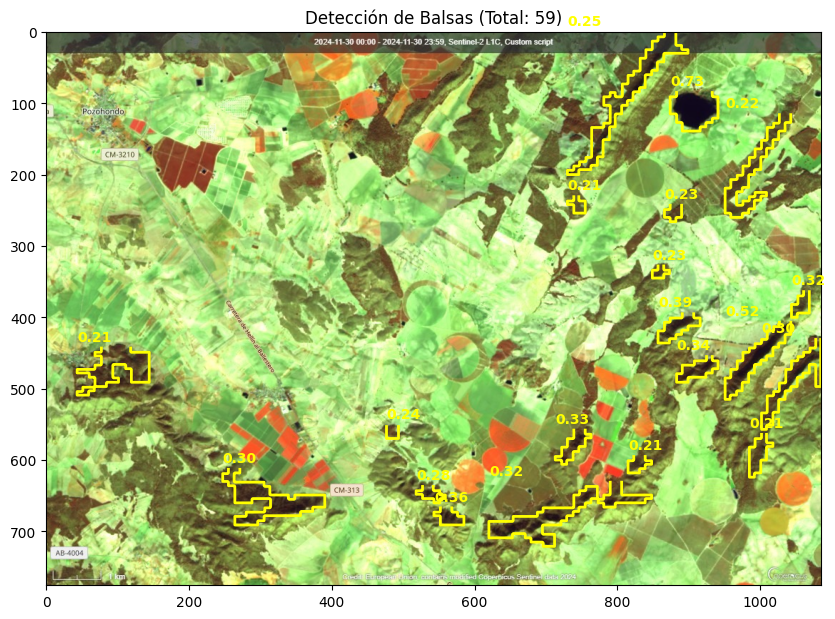

In [ ]:
from tensorflow import keras
from scipy.ndimage import label
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

#modelo_unet.save('/content/drive/MyDrive/imagenes_balsas/modelos/1.0modelo_unet.keras')

modelo_cargado = keras.models.load_model('/content/drive/MyDrive/imagenes_balsas/modelos/1.0modelo_unet.keras')

# Función para clasificar una nueva imagen
def clasificar_imagen_unet(imagen_path, modelo, size=(128, 128)):
    img = Image.open(imagen_path).resize(size)
    img_array = np.array(img) / 255.0
    prediccion = modelo.predict(np.expand_dims(img_array, axis=0))
    return prediccion[0, :, :, 0]



# Clasificación de imagen de prueba
imagen_prueba = "/content/drive/MyDrive/imagenes_balsas/Balsa29.jpg"
clasificacion = clasificar_imagen_unet(imagen_prueba, modelo_cargado)
clasificacion_binaria = (clasificacion > 0.1).astype(np.uint8)


estructura = np.ones((3, 3), dtype=int)
marcado, num_balsas = label(clasificacion_binaria, structure=estructura)

# Obtener dimensiones de la imagen original
imagen_original = Image.open(imagen_prueba)
ancho_original, alto_original = imagen_original.size

# Redimensionar la predicción a las dimensiones originales
clasificacion_redimensionada = cv2.resize(clasificacion_binaria, (ancho_original, alto_original), interpolation=cv2.INTER_NEAREST)

# Encontrar contornos en la predicción redimensionada
contornos, _ = cv2.findContours(clasificacion_redimensionada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Visualización del resultado
plt.figure(figsize=(10, 10))
plt.title(f"Detección de Balsas (Total: {num_balsas})")

# Mostrar la imagen original
plt.imshow(imagen_original)

# Dibujar contornos y bounding boxes en amarillo
for contorno in contornos:
    # Dibujar contorno
    #plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)

     # Calcular la probabilidad promedio dentro del contorno
    mascara = np.zeros_like(clasificacion_redimensionada, dtype=np.uint8)
    cv2.drawContours(mascara, [contorno], -1, 255, -1)

    # Redimensionar clasificacion para que coincida con la máscara
    clasificacion_resized = cv2.resize(clasificacion, (clasificacion_redimensionada.shape[1], clasificacion_redimensionada.shape[0]))

    probabilidad_promedio = np.mean(clasificacion_resized[mascara == 255])

     # Mostrar solo si la probabilidad es mayor a 0.2 (20%)
    if probabilidad_promedio > 0.2:
          # Dibujar contorno
          plt.plot(contorno[:, 0, 0], contorno[:, 0, 1], color='yellow', linewidth=2)

          # Mostrar la probabilidad como texto
          x, y, w, h = cv2.boundingRect(contorno)
          plt.text(x, y - 10, f"{probabilidad_promedio:.2f}", color='yellow', fontsize=10, fontweight='bold')





plt.show()






